# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

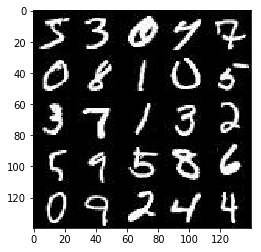

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

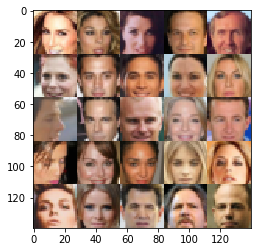

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # I'll try the suggested value(suggested in the DCGAN paper)
    # of stddev 0.02 for initializing weights
    # Unsupervised Representation Learning with
    # Deep Convolutional Generative Adversarial Networks:
    # https://arxiv.org/pdf/1511.06434.pdf
    # p.3, "4. Details of Adversarial Training"
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # layer1 with 28x28 size input
        # this layer should not have any batch normalization process
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME', kernel_initializer=kinit)

        # Leaky ReLU for discriminator layers, with alpha value of 0.2
        # as suggested in the DCGAN paper
        relu1 = tf.maximum(0.2 * x1, x1)
        # padding is 'same'
        # so ceil(28  / 2) = 14
        # now the shape is 14x14x64
        
        # layer2
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='SAME', kernel_initializer=kinit)
        # now batch normalization
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # now the shape is 7x7x128
        
        # layer3
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME', kernel_initializer=kinit)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        # now the shape is 4x4x256

        # flatten layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        
        # logits and outputs
        # the output node size should be 1
        # because discriminator tries to predict whether the image is real or fake (1 or 0)
        logits = tf.layers.dense(flat, 1, kernel_initializer=kinit)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    # variables should be reused when not training
    with tf.variable_scope("generator", reuse=not is_train):
        
        #x0 = tf.layers.dense(z, 1*1*256, kernel_initializer=kinit)
        #x0 = tf.reshape(x0, (-1, 1, 1, 256))
        #bn0 = tf.layers.batch_normalization(x0, training=is_train)
        #do0 = tf.layers.dropout(bn0, rate=0.2, training=is_train)
        #relu0 = tf.maximum(0.0, do0)
        
        # fully connected layer as the first layer
        # to get 7x7 shape via 'VALID' padding
        # this layer starts with 2x2 shape rather than 4x4
    
        x1 = tf.layers.dense(z, 2*2*1024, kernel_initializer=kinit)
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        #x1 = tf.layers.conv2d_transpose(relu0, 256, 5, strides=2,
        #                                padding='SAME', kernel_initializer=kinit)
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        
        # also suggested in the DLND forums and slacks
        # I applied dropout layers in generator model
        # this will hopefully make the model avoid overfitting problems
        # thus resulting a better model
        
        # but dropouts should only be applied when training
        # thus using all the weights when testing
        do1 = tf.layers.dropout(bn1, rate=0.4, training=is_train)
        
        # ReLU for generator layers
        # as suggested in the DCGAN paper
        relu1 = tf.maximum(0.0, do1)
        # now the shape is 2x2x256
        
        # layer2
        # when padding's 'VALID',
        # next_shape = ceil((shape - kernel_size + 1) / strides)
        # to get 7x7 from 2x2, 
        # 2 = ceil((7 - 5 + 1) / 2)
        # 2 = ceil((8 - 5 + 1) / 2)
        # tensorflow chooses the odd value (7 among 7 and 8) when
        # applying conv2d_tranpose with 'VALID' padding
        
        x2 = tf.layers.conv2d_transpose(relu1, 512, 5, strides=2,
                                        padding='VALID', kernel_initializer=kinit)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        do2 = tf.layers.dropout(bn2, rate=0.4, training=is_train)
        relu2 = tf.maximum(0.0, do2)
        # now the shape is 7x7x128
        
        # layer3
        x3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides=2,
                                        padding='SAME', kernel_initializer=kinit)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        do3 = tf.layers.dropout(bn3, rate=0.4, training=is_train)
        relu3 = tf.maximum(0.0, do3)
        # now the shape is 14x14x64
        
        # output layer
        # should not apply batch normalization here
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2,
                                            padding='SAME', kernel_initializer=kinit)
        # now the shape is 28x28xout_channel_dim
        
        # the value scale ranges from -0.5 to 0.5
        # so we should divide the tanh output which ranges from -1.0 to 1.0
        outputs = tf.tanh(logits)
        
    return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # generator model
    g_model = generator(input_z, out_channel_dim)
    
    # discriminator with real input
    d_model_real, d_logits_real = discriminator(input_real)
    
    # discriminator with fake input
    # real and fake models should have the same weights, so set reuse True
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # real loss
    # real data's labels should all be 1
    # this is not suggested in the DCGAN paper, but
    # I'll try to apply label smoothing as shown in the DLND lectures
    # with 0.1 label smoothing (i.e multiplying by (1 - 0.1) which is 0.9)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * 0.9))

    # and 0 for fake labels
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))

    # sum of real and fake losses should be the discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    # now the generator loss
    # this should be the opposite to d_loss_fake
    # because generator wants to fool the discriminator
    # also applied label smoothing here as well
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake) * 0.9))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # get variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'discriminator' in var.name]
    g_vars = [var for var in t_vars if 'generator' in var.name]
    
    # to update population statistics for batch normalization
    # wrap the train operations with tf.control_dependencies
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # lists to store losses while training
    d_losses = []
    g_losses = []
    
    # get the parameters for the placeholder function
    
    # width and height
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    # color channels
    if data_image_mode == "RGB":
        image_channels = 3
    elif data_image_mode == "L":
        image_channels = 1
    else:
        return "data_image_mode argument should be either 'RGB' or 'L'"
    
    # build placeholders
    input_real, input_z, lr = model_inputs(image_width,
                                           image_height,
                                           image_channels,
                                           z_dim)
    
    # build losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # build optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # initialize steps (show every 100 steps)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # batch image's values range from -0.5 to 0.5
                # so we multiply them by 2
                # to fit the tanh output which ranges from -1 to 1
                batch_images = batch_images * 2.0
                
                # random noise for generator
                # the range should be the same as shown in
                # show_generator_output() function
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                if steps % 2 == 0:
                    _ = sess.run(d_opt, feed_dict={input_real:batch_images,
                                                   input_z:batch_z,
                                                   lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images,
                                               input_z:batch_z,
                                               lr:learning_rate})
                
                # show generator output and loss every 100 steps
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    d_losses.append(train_loss_d)
                    g_losses.append(train_loss_g)

            # show loss every epoch
            train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z})

            print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))

    # plot learning curves
    pyplot.plot(d_losses, label='d_loss')
    pyplot.plot(g_losses, label='g_loss')
    pyplot.legend()
    pyplot.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

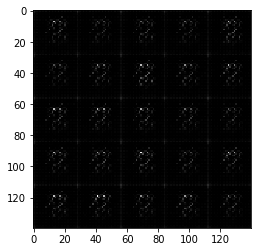

Discriminator Loss: 0.7746... Generator Loss: 1.1228


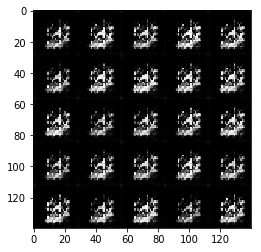

Discriminator Loss: 0.6754... Generator Loss: 2.4747


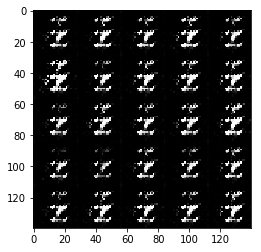

Discriminator Loss: 0.4366... Generator Loss: 2.9581


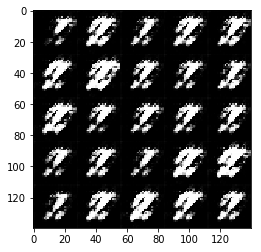

Discriminator Loss: 0.4826... Generator Loss: 2.3590


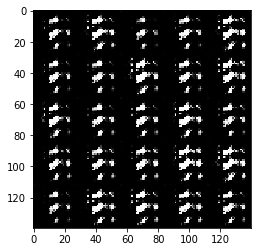

Discriminator Loss: 0.5203... Generator Loss: 4.6413


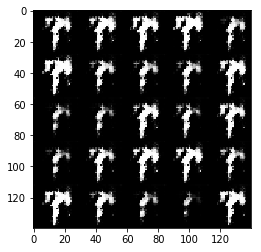

Discriminator Loss: 0.4660... Generator Loss: 2.9351


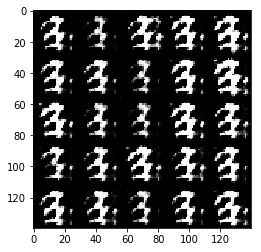

Discriminator Loss: 0.4249... Generator Loss: 3.7097


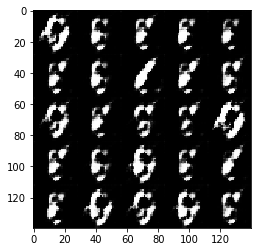

Discriminator Loss: 0.7547... Generator Loss: 1.3318


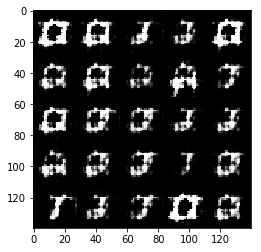

Discriminator Loss: 0.6374... Generator Loss: 2.3798


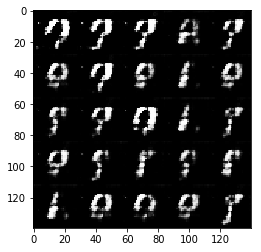

Discriminator Loss: 0.8337... Generator Loss: 3.4396


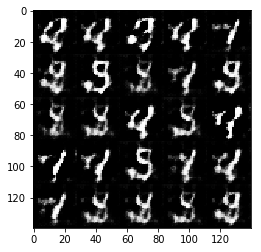

Discriminator Loss: 1.4599... Generator Loss: 3.2336


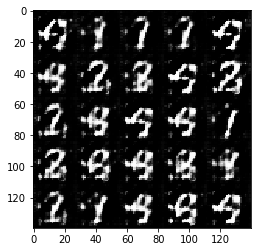

Discriminator Loss: 0.6768... Generator Loss: 1.8575


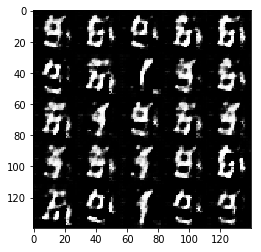

Discriminator Loss: 0.7921... Generator Loss: 2.3431


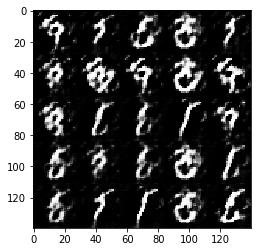

Discriminator Loss: 0.7962... Generator Loss: 1.3659


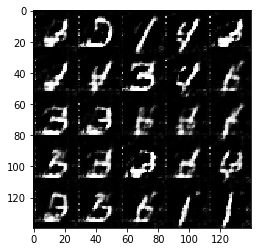

Discriminator Loss: 0.8155... Generator Loss: 1.7227


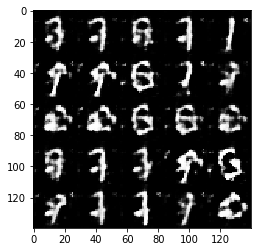

Discriminator Loss: 0.8247... Generator Loss: 1.6863


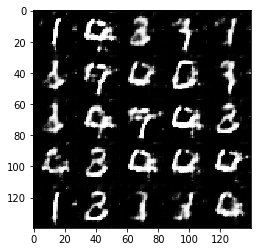

Discriminator Loss: 0.8829... Generator Loss: 1.6935


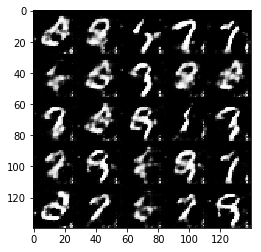

Discriminator Loss: 0.6681... Generator Loss: 1.6922


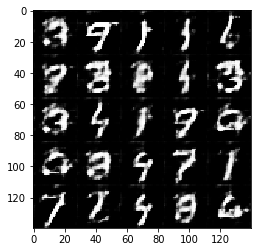

Discriminator Loss: 0.7608... Generator Loss: 1.5242


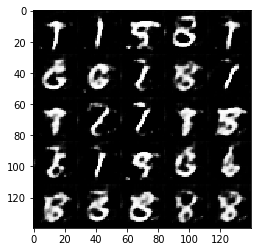

Discriminator Loss: 0.9683... Generator Loss: 1.1383


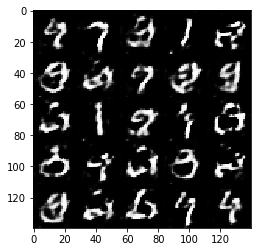

Discriminator Loss: 1.1143... Generator Loss: 0.7824


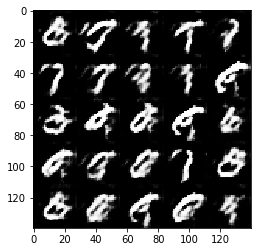

Discriminator Loss: 0.6699... Generator Loss: 2.3439


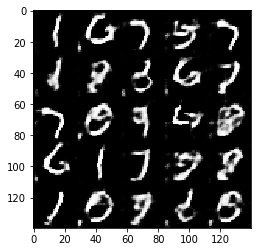

Discriminator Loss: 0.7200... Generator Loss: 1.5529


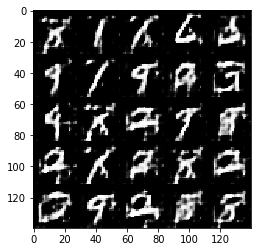

Discriminator Loss: 0.7216... Generator Loss: 2.3684


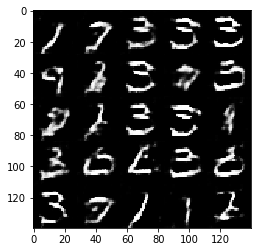

Discriminator Loss: 0.8164... Generator Loss: 1.6474


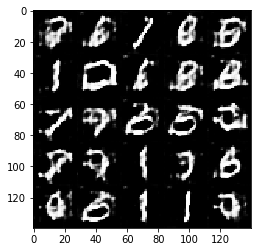

Discriminator Loss: 1.0711... Generator Loss: 1.9450


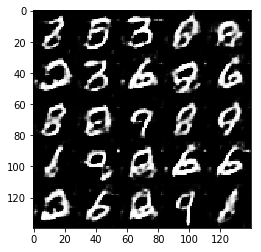

Discriminator Loss: 0.8049... Generator Loss: 1.1767


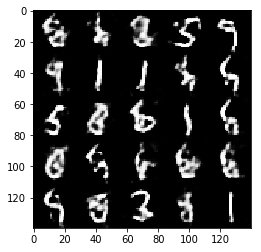

Discriminator Loss: 1.2032... Generator Loss: 0.9533


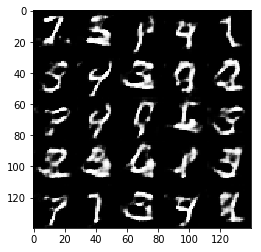

Discriminator Loss: 0.7655... Generator Loss: 1.3132


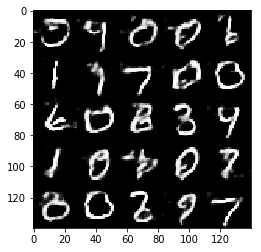

Discriminator Loss: 1.0520... Generator Loss: 0.9105


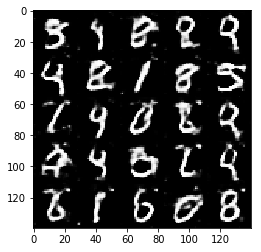

Discriminator Loss: 1.0150... Generator Loss: 0.9082


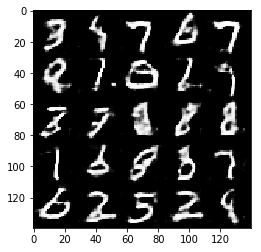

Discriminator Loss: 1.0799... Generator Loss: 1.0841


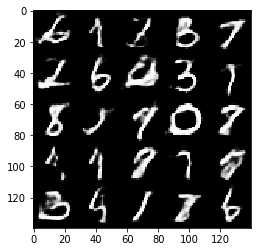

Discriminator Loss: 0.8729... Generator Loss: 1.8434


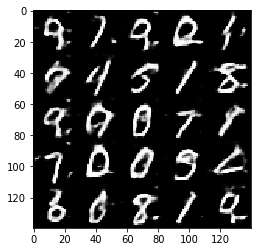

Discriminator Loss: 0.9800... Generator Loss: 1.5886


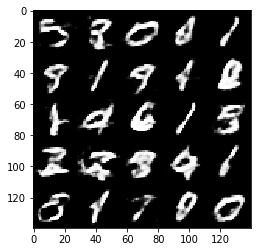

Discriminator Loss: 1.0253... Generator Loss: 1.4698


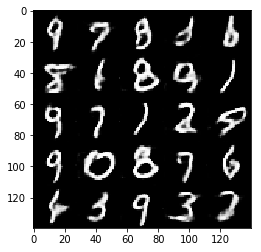

Discriminator Loss: 0.7363... Generator Loss: 1.4947


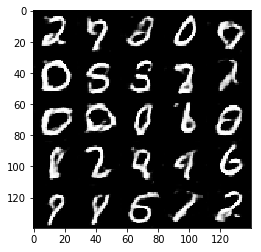

Discriminator Loss: 0.9834... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 0.7666... Generator Loss: 1.4026


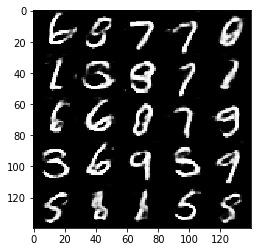

Discriminator Loss: 0.8710... Generator Loss: 1.3592


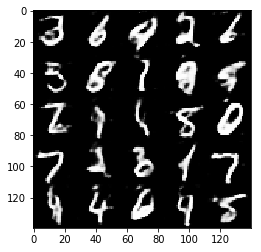

Discriminator Loss: 0.7819... Generator Loss: 1.2858


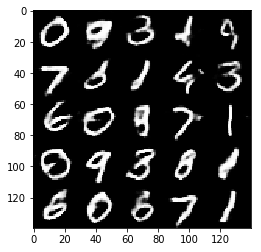

Discriminator Loss: 0.8549... Generator Loss: 1.1714


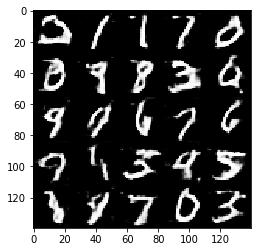

Discriminator Loss: 0.6926... Generator Loss: 1.3714


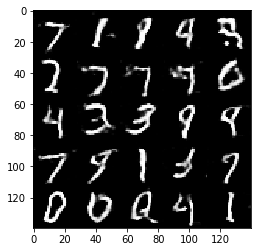

Discriminator Loss: 0.8979... Generator Loss: 0.8444


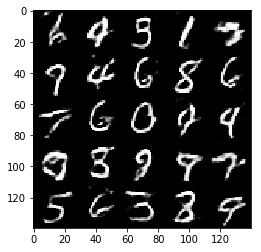

Discriminator Loss: 1.1640... Generator Loss: 0.7796


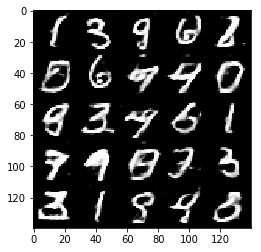

Discriminator Loss: 1.2771... Generator Loss: 0.5928


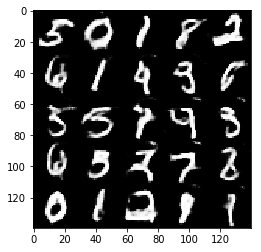

Discriminator Loss: 1.0806... Generator Loss: 0.8954


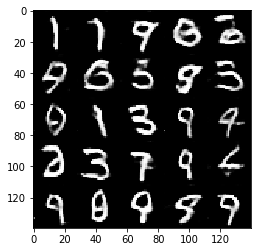

Discriminator Loss: 0.7984... Generator Loss: 1.2682


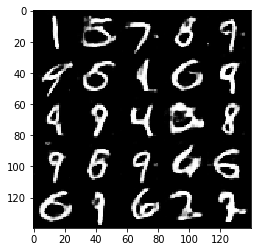

Discriminator Loss: 0.8146... Generator Loss: 1.2101


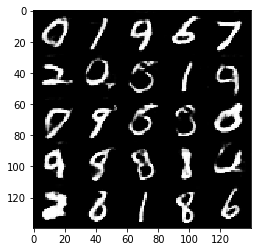

Discriminator Loss: 0.9857... Generator Loss: 0.9716


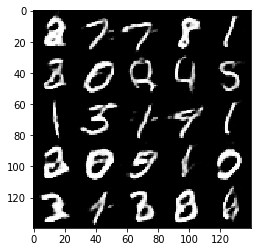

Discriminator Loss: 0.9920... Generator Loss: 0.8655


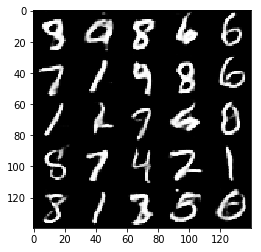

Discriminator Loss: 0.9232... Generator Loss: 1.2461


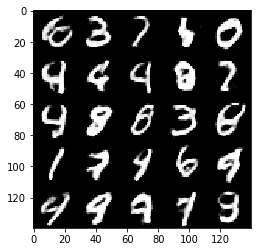

Discriminator Loss: 0.9299... Generator Loss: 1.2301


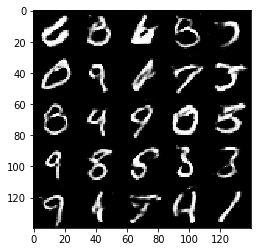

Discriminator Loss: 0.7557... Generator Loss: 1.3108


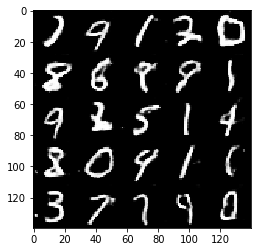

Discriminator Loss: 0.8029... Generator Loss: 1.3139


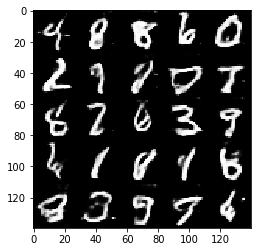

Discriminator Loss: 1.2435... Generator Loss: 0.6833


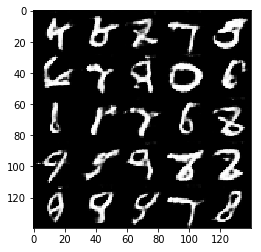

Discriminator Loss: 0.9758... Generator Loss: 0.9825


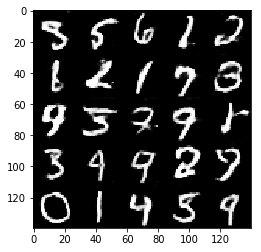

Discriminator Loss: 0.8508... Generator Loss: 1.2673


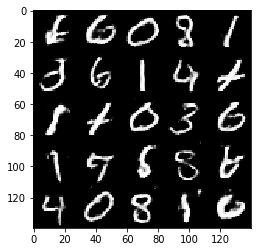

Discriminator Loss: 0.8418... Generator Loss: 1.3062


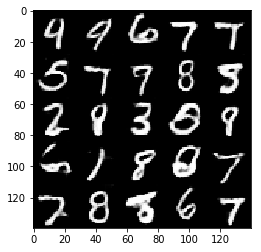

Discriminator Loss: 0.7987... Generator Loss: 1.1535


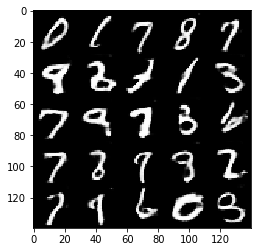

Discriminator Loss: 1.0810... Generator Loss: 1.0604


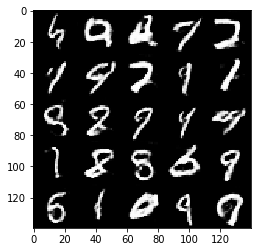

Discriminator Loss: 0.7630... Generator Loss: 1.0952


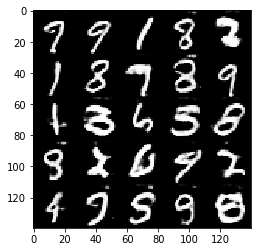

Discriminator Loss: 0.5945... Generator Loss: 1.4370


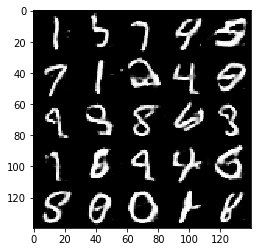

Discriminator Loss: 0.7951... Generator Loss: 1.1497


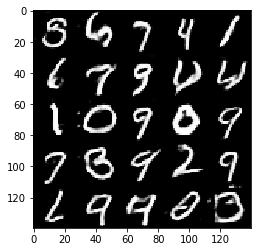

Discriminator Loss: 0.6585... Generator Loss: 1.5114


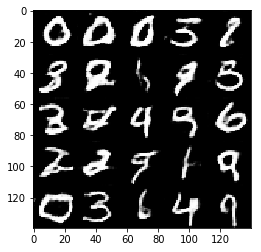

Discriminator Loss: 0.7608... Generator Loss: 1.6658


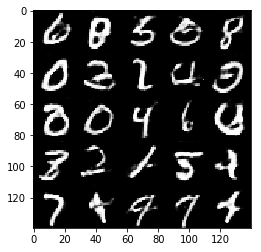

Discriminator Loss: 0.7815... Generator Loss: 1.0093


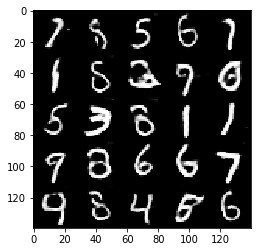

Discriminator Loss: 0.8564... Generator Loss: 0.8709


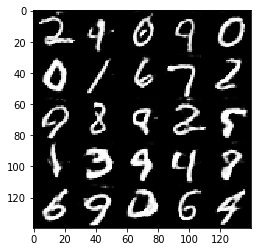

Discriminator Loss: 0.8350... Generator Loss: 1.8360


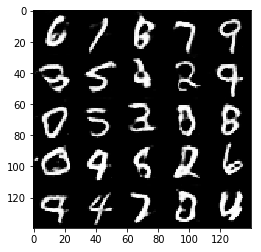

Discriminator Loss: 0.5769... Generator Loss: 1.5234


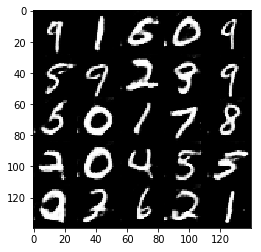

Discriminator Loss: 0.8298... Generator Loss: 1.0293


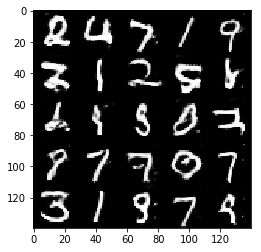

Discriminator Loss: 0.8084... Generator Loss: 1.0261


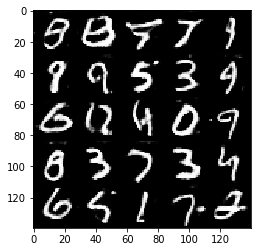

Discriminator Loss: 0.6335... Generator Loss: 1.4078


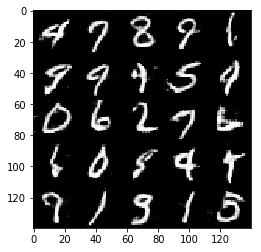

Discriminator Loss: 1.3491... Generator Loss: 1.3225


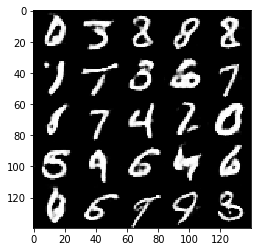

Discriminator Loss: 0.6615... Generator Loss: 1.5279


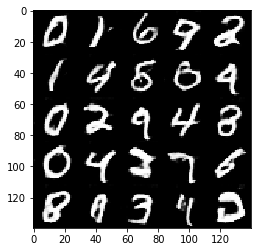

Discriminator Loss: 0.6956... Generator Loss: 1.2197


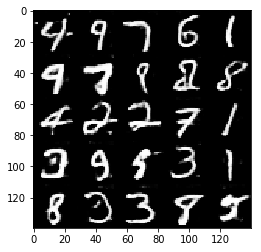

Discriminator Loss: 0.6249... Generator Loss: 2.3333
Epoch 2/2... Discriminator Loss: 0.6365... Generator Loss: 1.8762


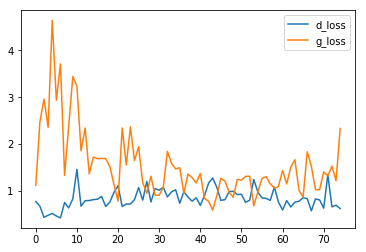

In [24]:
# these values are suggested in the DCGAN paper
# batch size of 128, learning rate of 0.0002
# and beta1 of 16
# however after many tries, I noticed that
# for this MNIST problem, smaller batch size works better
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5

# 1.4373
# batch 128, beta 0.5, lr 0.0002, dr 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.